In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
hos_refferals = pd.read_csv('../data/hos_referrals.csv')
neo_communites =  pd.read_csv('../data/neo_communities.csv')
nashville_npi = pd.read_csv('../data/nashville_npi.csv')

In [3]:
hos_refferals = hos_refferals[~hos_refferals['from_classification'
                                            ].isin(['Radiology', 
                                                    'Pathology', 
                                                    'Durable Medical Equipment & Medical Supplies', 
                                                    'Ambulance'])]

In [4]:
hos_refferals = hos_refferals[hos_refferals['to_npi'].isin(nashville_npi['npi'].to_list())]

In [5]:
hos_refferals = hos_refferals.merge(neo_communites, how = 'left', left_on = 'from_npi', right_on = 'npi'
                   ).rename(columns={"communityId": "from_communityId"}
                           ).merge(neo_communites, how = 'left', left_on = 'to_npi', right_on = 'npi'
                                  ).rename(columns={"communityId": "to_communityId"}
                                          ).drop(columns = ['npi_x', 'npi_y'])

In [6]:
cols = [
    'from_npi', 
    'from_organization', 
    'from_classification', 
    'from_communityId', 
    'to_communityId', 
    'to_organization', 
    'patient_count']

In [7]:
hos_refferals = hos_refferals[cols]

In [8]:
hos_refferals = hos_refferals.groupby(by = ['from_npi', 
    'from_organization', 
    'from_classification', 
    'from_communityId', 
    'to_communityId', 
    'to_organization'], dropna = False).sum().reset_index()

In [9]:
to_data_class = hos_refferals[['from_classification', 'to_organization', 'patient_count']
             ].groupby(by = ['from_classification', 'to_organization'], dropna = False).sum().reset_index()

In [10]:
patient_totals_class = hos_refferals[['from_classification', 'patient_count']].groupby(by = ['from_classification'], dropna = False
                                                                     ).sum().rename(columns={"patient_count": "patient_totals"}
                                                                                   ).reset_index()

In [11]:
refferals_class = to_data_class.merge(patient_totals_class, how = 'left', on = 'from_classification')

In [12]:
refferals_class['patient_percent'] = refferals_class['patient_count'] / refferals_class['patient_totals']

In [13]:
vandy_low_class = refferals_class[(refferals_class['to_organization'] == 'VANDERBILT UNIVERSITY MEDICAL CENTER') & 
          (refferals_class['patient_percent'] < .60) &
          (refferals_class['patient_totals'] > 25000)].sort_values(by = ['patient_percent']).reset_index().drop(columns = ['index'])

In [14]:
vandy_low_class

,from_classification,to_organization,patient_count,patient_totals,patient_percent
0,Specialist,VANDERBILT UNIVERSITY MEDICAL CENTER,10970,57680,0.190187
1,"Nurse Anesthetist, Certified Registered",VANDERBILT UNIVERSITY MEDICAL CENTER,11321,41760,0.271097
2,Anesthesiology,VANDERBILT UNIVERSITY MEDICAL CENTER,21938,72616,0.302110
3,Emergency Medicine,VANDERBILT UNIVERSITY MEDICAL CENTER,29632,92939,0.318833
4,Surgery,VANDERBILT UNIVERSITY MEDICAL CENTER,9821,30778,0.319092
5,Orthopaedic Surgery,VANDERBILT UNIVERSITY MEDICAL CENTER,12978,34693,0.374081
6,Internal Medicine,VANDERBILT UNIVERSITY MEDICAL CENTER,276305,598241,0.461862
7,General Acute Care Hospital,VANDERBILT UNIVERSITY MEDICAL CENTER,41139,87865,0.468207
8,Psychiatry & Neurology,VANDERBILT UNIVERSITY MEDICAL CENTER,18542,35378,0.524111
9,Nurse Practitioner,VANDERBILT UNIVERSITY MEDICAL CENTER,41696,77062,0.541071


In [15]:
vandy_low_class['no_vandy'] = vandy_low_class['patient_totals'] - vandy_low_class['patient_count']

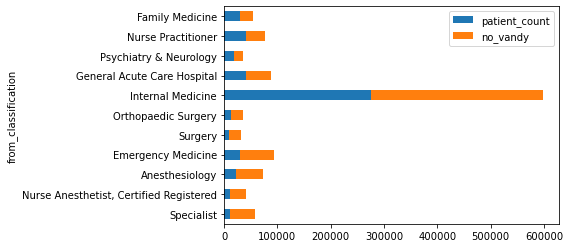

In [16]:
vandy_low_class[['from_classification', 'patient_count', 'no_vandy']].plot(kind = 'barh', x = 'from_classification', stacked = True)
plt.show()

In [17]:
em = refferals_class[(refferals_class['from_classification'] == 'Emergency Medicine')].sort_values(by = ['patient_percent'], ascending = False).reset_index(drop = True).head()

In [18]:
em.loc[len(em.index)] = ['Emergency Medicine', 'Other', 
 em['patient_totals'][0] - sum(em['patient_count']), 
 em['patient_totals'][0], 
1 - sum(em['patient_percent'])]

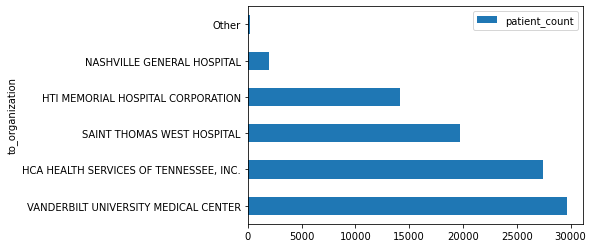

In [19]:
em[['to_organization', 'patient_count']].plot(kind = 'barh', x = 'to_organization')
plt.show()

In [20]:
hos_refferals.loc[hos_refferals['from_classification'] == 'Emergency Medicine'].sort_values(by = ['patient_count'], ascending = False).head(15)

,from_npi,from_organization,from_classification,from_communityId,to_communityId,to_organization,patient_count
1150,1184052235,DOVERSIDE EMERGENCY PHYSICIANS PLLC,Emergency Medicine,195,195,HTI MEMORIAL HOSPITAL CORPORATION,5157
1250,1194758979,MIDDLE TENNESSEE EMERGENCY PHYSICIANS PC,Emergency Medicine,29,10,SAINT THOMAS WEST HOSPITAL,4905
1788,1275942013,LONGS PARK EMERGENCY PHYSICIANS PLLC,Emergency Medicine,195,195,"HCA HEALTH SERVICES OF TENNESSEE, INC.",3817
457,1073922829,MONADNOCK EMERGENCY PHYSICIANS PLLC,Emergency Medicine,195,195,"HCA HEALTH SERVICES OF TENNESSEE, INC.",2476
2239,1356379382,SOUTHEASTERN EMERGENCY PHYSICIANS LLC,Emergency Medicine,1209,268,VANDERBILT UNIVERSITY MEDICAL CENTER,2385
3141,1497725873,EMERGI-TRUST,Emergency Medicine,268,268,VANDERBILT UNIVERSITY MEDICAL CENTER,1700
4033,1639588015,HOSPITAL BASED MEDICAL SERVICES OF TENNESSEE-I PC,Emergency Medicine,195,195,"HCA HEALTH SERVICES OF TENNESSEE, INC.",1615
19,1003230236,"APP OF TENNESSEE ED, PLLC",Emergency Medicine,10,268,VANDERBILT UNIVERSITY MEDICAL CENTER,1611
17,1003230236,"APP OF TENNESSEE ED, PLLC",Emergency Medicine,10,10,SAINT THOMAS WEST HOSPITAL,1167
2683,1427005008,EMERGENCY COVERAGE CORP,Emergency Medicine,1209,268,VANDERBILT UNIVERSITY MEDICAL CENTER,963


In [21]:
hos_refferals.loc[hos_refferals['from_organization'] == 'MIDDLE TENNESSEE EMERGENCY PHYSICIANS PC'].sort_values(by = ['patient_count'], ascending = False).head(15)

,from_npi,from_organization,from_classification,from_communityId,to_communityId,to_organization,patient_count
1250,1194758979,MIDDLE TENNESSEE EMERGENCY PHYSICIANS PC,Emergency Medicine,29,10,SAINT THOMAS WEST HOSPITAL,4905
1254,1194758979,MIDDLE TENNESSEE EMERGENCY PHYSICIANS PC,Emergency Medicine,29,1209,NASHVILLE GENERAL HOSPITAL,112
1252,1194758979,MIDDLE TENNESSEE EMERGENCY PHYSICIANS PC,Emergency Medicine,29,195,"HCA HEALTH SERVICES OF TENNESSEE, INC.",95
1251,1194758979,MIDDLE TENNESSEE EMERGENCY PHYSICIANS PC,Emergency Medicine,29,29,SETON CORPORATION,91
1249,1194758979,MIDDLE TENNESSEE EMERGENCY PHYSICIANS PC,Emergency Medicine,29,10,BAPTIST WOMEN'S HEALTH CENTER LLC,82
1253,1194758979,MIDDLE TENNESSEE EMERGENCY PHYSICIANS PC,Emergency Medicine,29,268,VANDERBILT UNIVERSITY MEDICAL CENTER,61


In [22]:
a = refferals_class[(refferals_class['from_classification'] == 'Anesthesiology')].sort_values(by = ['patient_percent'], ascending = False).reset_index(drop = True).head()

In [23]:
a.loc[len(em.index)] = ['Anesthesiology', 'Other', 
 a['patient_totals'][0] - sum(a['patient_count']), 
 a['patient_totals'][0], 
1 - sum(a['patient_percent'])]

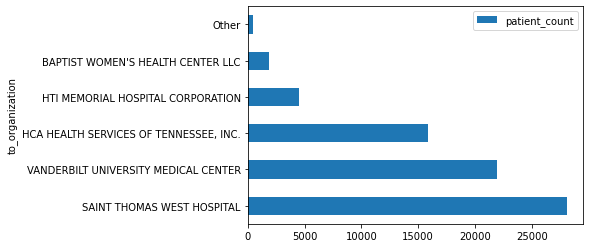

In [24]:
a[['to_organization', 'patient_count']].plot(kind = 'barh', x = 'to_organization')
plt.show()

In [25]:
hos_refferals.loc[hos_refferals['from_classification'] == 'Anesthesiology'].sort_values(by = ['patient_count'], ascending = False).head(15)

,from_npi,from_organization,from_classification,from_communityId,to_communityId,to_organization,patient_count
1397,1215932413,"ANESTHESIA MEDICAL GROUP, PC",Anesthesiology,195,195,"HCA HEALTH SERVICES OF TENNESSEE, INC.",9715
1394,1215932413,"ANESTHESIA MEDICAL GROUP, PC",Anesthesiology,195,10,SAINT THOMAS WEST HOSPITAL,9609
5711,1912953381,CARDIOVASCULAR ANESTHESIOLOGISTS PC,Anesthesiology,1209,10,SAINT THOMAS WEST HOSPITAL,6975
1398,1215932413,"ANESTHESIA MEDICAL GROUP, PC",Anesthesiology,195,195,HTI MEMORIAL HOSPITAL CORPORATION,2853
2126,1336223452,NaN,Anesthesiology,268,268,VANDERBILT UNIVERSITY MEDICAL CENTER,1103
1393,1215932413,"ANESTHESIA MEDICAL GROUP, PC",Anesthesiology,195,10,BAPTIST WOMEN'S HEALTH CENTER LLC,1076
649,1104854124,ANESTHESIA SERVICES ASSOCIATES PLLC,Anesthesiology,1262,268,VANDERBILT UNIVERSITY MEDICAL CENTER,989
5609,1902049893,NaN,Anesthesiology,10,10,SAINT THOMAS WEST HOSPITAL,763
4991,1790958593,NaN,Anesthesiology,10,10,SAINT THOMAS WEST HOSPITAL,720
648,1104854124,ANESTHESIA SERVICES ASSOCIATES PLLC,Anesthesiology,1262,195,"HCA HEALTH SERVICES OF TENNESSEE, INC.",625


In [26]:
hos_refferals.loc[hos_refferals['from_organization'] == 'ANESTHESIA MEDICAL GROUP, PC'].sort_values(by = ['patient_count'], ascending = False).head(15)

,from_npi,from_organization,from_classification,from_communityId,to_communityId,to_organization,patient_count
1397,1215932413,"ANESTHESIA MEDICAL GROUP, PC",Anesthesiology,195,195,"HCA HEALTH SERVICES OF TENNESSEE, INC.",9715
1394,1215932413,"ANESTHESIA MEDICAL GROUP, PC",Anesthesiology,195,10,SAINT THOMAS WEST HOSPITAL,9609
1398,1215932413,"ANESTHESIA MEDICAL GROUP, PC",Anesthesiology,195,195,HTI MEMORIAL HOSPITAL CORPORATION,2853
1393,1215932413,"ANESTHESIA MEDICAL GROUP, PC",Anesthesiology,195,10,BAPTIST WOMEN'S HEALTH CENTER LLC,1076
1395,1215932413,"ANESTHESIA MEDICAL GROUP, PC",Anesthesiology,195,10,SELECT SPECIALTY HOSPITAL - NASHVILLE LLC,148
1396,1215932413,"ANESTHESIA MEDICAL GROUP, PC",Anesthesiology,195,29,SETON CORPORATION,99


In [27]:
hos_refferals.loc[hos_refferals['from_organization'] == 'CARDIOVASCULAR ANESTHESIOLOGISTS PC'].sort_values(by = ['patient_count'], ascending = False).head(15)

,from_npi,from_organization,from_classification,from_communityId,to_communityId,to_organization,patient_count
5711,1912953381,CARDIOVASCULAR ANESTHESIOLOGISTS PC,Anesthesiology,1209,10,SAINT THOMAS WEST HOSPITAL,6975
5710,1912953381,CARDIOVASCULAR ANESTHESIOLOGISTS PC,Anesthesiology,1209,10,BAPTIST WOMEN'S HEALTH CENTER LLC,268


In [28]:
fm = refferals_class[(refferals_class['from_classification'] == 'Family Medicine')].sort_values(by = ['patient_percent'], ascending = False).reset_index(drop = True).head()

In [29]:
fm.loc[len(em.index)] = ['Family Medicine', 'Other', 
 fm['patient_totals'][0] - sum(fm['patient_count']), 
 fm['patient_totals'][0], 
1 - sum(fm['patient_percent'])]

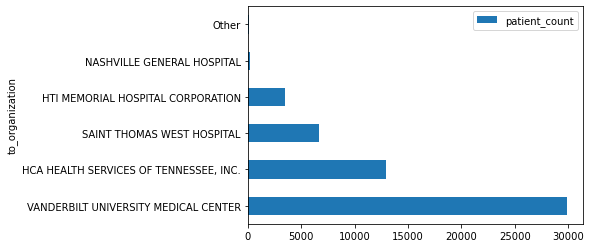

In [30]:
fm[['to_organization', 'patient_count']].plot(kind = 'barh', x = 'to_organization')
plt.show()

In [31]:
hos_refferals.loc[hos_refferals['from_classification'] == 'Family Medicine'].sort_values(by = ['patient_count'], ascending = False).head(15)

,from_npi,from_organization,from_classification,from_communityId,to_communityId,to_organization,patient_count
4430,1700873171,COLUMBIA MEDICAL GROUP-SOUTHERN HILLS INC,Family Medicine,195,195,"HCA HEALTH SERVICES OF TENNESSEE, INC.",2995
1332,1205886264,"MAURY REGIONAL MEDICAL GROUP, INC",Family Medicine,1209,268,VANDERBILT UNIVERSITY MEDICAL CENTER,1772
5785,1922401611,BAPTIST HEALTH MEDICAL GROUP INC,Family Medicine,268,268,VANDERBILT UNIVERSITY MEDICAL CENTER,1376
5756,1922243690,MERCY HEALTH PHYSICIANS KENTUCKY LLC,Family Medicine,268,268,VANDERBILT UNIVERSITY MEDICAL CENTER,984
3580,1568464873,DICKSON MEDICAL ASSOCIATES PC,Family Medicine,195,195,"HCA HEALTH SERVICES OF TENNESSEE, INC.",870
3579,1568464873,DICKSON MEDICAL ASSOCIATES PC,Family Medicine,195,10,SAINT THOMAS WEST HOSPITAL,856
2881,1457302010,"COVENANT MEDICAL GROUP, INC.",Family Medicine,2210,268,VANDERBILT UNIVERSITY MEDICAL CENTER,740
5783,1922394840,NaN,Family Medicine,195,195,HTI MEMORIAL HOSPITAL CORPORATION,740
3581,1568464873,DICKSON MEDICAL ASSOCIATES PC,Family Medicine,195,268,VANDERBILT UNIVERSITY MEDICAL CENTER,679
3022,1477548154,NaN,Family Medicine,195,195,"HCA HEALTH SERVICES OF TENNESSEE, INC.",673


In [32]:
hos_refferals.loc[hos_refferals['from_organization'] == 'DICKSON MEDICAL ASSOCIATES PC'].sort_values(by = ['patient_count'], ascending = False).head(15)

,from_npi,from_organization,from_classification,from_communityId,to_communityId,to_organization,patient_count
3580,1568464873,DICKSON MEDICAL ASSOCIATES PC,Family Medicine,195,195,"HCA HEALTH SERVICES OF TENNESSEE, INC.",870
3579,1568464873,DICKSON MEDICAL ASSOCIATES PC,Family Medicine,195,10,SAINT THOMAS WEST HOSPITAL,856
3581,1568464873,DICKSON MEDICAL ASSOCIATES PC,Family Medicine,195,268,VANDERBILT UNIVERSITY MEDICAL CENTER,679


In [33]:
os = refferals_class[(refferals_class['from_classification'] == 'Orthopaedic Surgery')].sort_values(by = ['patient_percent'], ascending = False).reset_index(drop = True).head()

In [34]:
os.loc[len(os.index)] = ['Orthopaedic Surgery', 'Other', 
 os['patient_totals'][0] - sum(os['patient_count']), 
 os['patient_totals'][0], 
1 - sum(os['patient_percent'])]

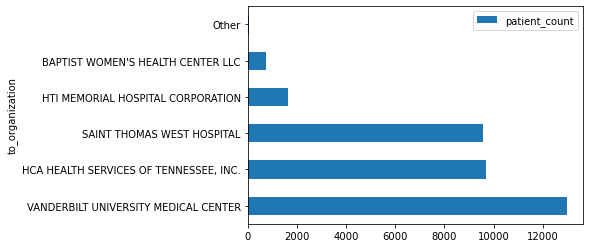

In [35]:
os[['to_organization', 'patient_count']].plot(kind = 'barh', x = 'to_organization')
plt.show()

In [36]:
hos_refferals.loc[hos_refferals['from_classification'] == 'Orthopaedic Surgery'].sort_values(by = ['patient_count'], ascending = False).head(15)

,from_npi,from_organization,from_classification,from_communityId,to_communityId,to_organization,patient_count
3397,1538153937,TENNESSEE ORTHOPAEDIC ALLIANCE PA,Orthopaedic Surgery,10,10,SAINT THOMAS WEST HOSPITAL,5371
3399,1538153937,TENNESSEE ORTHOPAEDIC ALLIANCE PA,Orthopaedic Surgery,10,268,VANDERBILT UNIVERSITY MEDICAL CENTER,3194
3398,1538153937,TENNESSEE ORTHOPAEDIC ALLIANCE PA,Orthopaedic Surgery,10,195,"HCA HEALTH SERVICES OF TENNESSEE, INC.",2260
1070,1164834057,"TRISTAR JOINT REPLACEMENT INSTITUTE, LLC",Orthopaedic Surgery,195,195,"HCA HEALTH SERVICES OF TENNESSEE, INC.",1500
2876,1447758933,BONE AND JOINT INSTITUTE OF TENNESSEE INC,Orthopaedic Surgery,268,268,VANDERBILT UNIVERSITY MEDICAL CENTER,1182
6054,1972577351,PREMIER ORTHOPAEDICS & SPORTS MEDICINE PLC,Orthopaedic Surgery,195,195,"HCA HEALTH SERVICES OF TENNESSEE, INC.",1130
3872,1619064722,NaN,Orthopaedic Surgery,268,268,VANDERBILT UNIVERSITY MEDICAL CENTER,525
6055,1972577351,PREMIER ORTHOPAEDICS & SPORTS MEDICINE PLC,Orthopaedic Surgery,195,195,HTI MEMORIAL HOSPITAL CORPORATION,491
3396,1538153937,TENNESSEE ORTHOPAEDIC ALLIANCE PA,Orthopaedic Surgery,10,10,BAPTIST WOMEN'S HEALTH CENTER LLC,480
1626,1255488128,NaN,Orthopaedic Surgery,268,268,VANDERBILT UNIVERSITY MEDICAL CENTER,464


In [37]:
im = refferals_class[(refferals_class['from_classification'] == 'Internal Medicine')].sort_values(by = ['patient_percent'], ascending = False).reset_index(drop = True).head()

In [38]:
im.loc[len(im.index)] = ['Internal Medicine', 'Other', 
 im['patient_totals'][0] - sum(im['patient_count']), 
 im['patient_totals'][0], 
1 - sum(im['patient_percent'])]

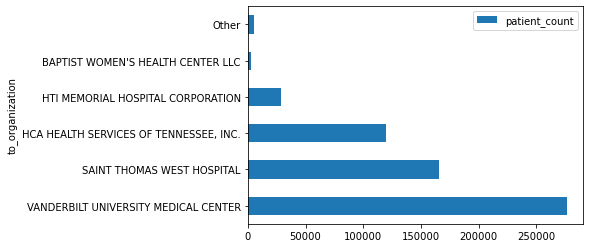

In [39]:
im[['to_organization', 'patient_count']].plot(kind = 'barh', x = 'to_organization')
plt.show()

In [40]:
hos_refferals.loc[hos_refferals['from_classification'] == 'Internal Medicine'].sort_values(by = ['patient_count'], ascending = False).head(15)

,from_npi,from_organization,from_classification,from_communityId,to_communityId,to_organization,patient_count
607,1104202761,VANDERBILT UNIVERSITY MEDICAL CENTER,Internal Medicine,268,268,VANDERBILT UNIVERSITY MEDICAL CENTER,63712
545,1093741464,"ADVANCED DIAGNOSTIC IMAGING, PC",Internal Medicine,10,10,SAINT THOMAS WEST HOSPITAL,27212
2770,1437194669,SAINT THOMAS MEDICAL PARTNERS,Internal Medicine,10,10,SAINT THOMAS WEST HOSPITAL,24629
551,1093741464,"ADVANCED DIAGNOSTIC IMAGING, PC",Internal Medicine,10,268,VANDERBILT UNIVERSITY MEDICAL CENTER,11901
4245,1679560023,COLUMBIA MEDICAL GROUP - THE FRIST CLINIC INC,Internal Medicine,195,195,"HCA HEALTH SERVICES OF TENNESSEE, INC.",9924
2774,1437194669,SAINT THOMAS MEDICAL PARTNERS,Internal Medicine,10,268,VANDERBILT UNIVERSITY MEDICAL CENTER,7456
3458,1548284060,HERITAGE MEDICAL ASSOCIATES PC,Internal Medicine,10,10,SAINT THOMAS WEST HOSPITAL,7323
549,1093741464,"ADVANCED DIAGNOSTIC IMAGING, PC",Internal Medicine,10,195,"HCA HEALTH SERVICES OF TENNESSEE, INC.",6610
2607,1417131715,NaN,Internal Medicine,195,195,"HCA HEALTH SERVICES OF TENNESSEE, INC.",6408
6090,1982013728,MARATHON INPATIENT SERVICES PLLC,Internal Medicine,195,195,"HCA HEALTH SERVICES OF TENNESSEE, INC.",4383


In [41]:
hos_refferals.loc[hos_refferals['from_organization'] == 'TENNESSEE ONCOLOGY PLLC'].sort_values(by = ['patient_count'], ascending = False).head(15)

,from_npi,from_organization,from_classification,from_communityId,to_communityId,to_organization,patient_count
5109,1811955917,TENNESSEE ONCOLOGY PLLC,Internal Medicine,29,10,SAINT THOMAS WEST HOSPITAL,3794
5112,1811955917,TENNESSEE ONCOLOGY PLLC,Internal Medicine,29,195,"HCA HEALTH SERVICES OF TENNESSEE, INC.",3101
4049,1649228735,TENNESSEE ONCOLOGY PLLC,Internal Medicine,29,10,SAINT THOMAS WEST HOSPITAL,3011
4051,1649228735,TENNESSEE ONCOLOGY PLLC,Internal Medicine,29,195,"HCA HEALTH SERVICES OF TENNESSEE, INC.",2637
5114,1811955917,TENNESSEE ONCOLOGY PLLC,Internal Medicine,29,268,VANDERBILT UNIVERSITY MEDICAL CENTER,2318
4053,1649228735,TENNESSEE ONCOLOGY PLLC,Internal Medicine,29,268,VANDERBILT UNIVERSITY MEDICAL CENTER,1946
1429,1225081912,TENNESSEE ONCOLOGY PLLC,Internal Medicine,29,10,SAINT THOMAS WEST HOSPITAL,1055
5113,1811955917,TENNESSEE ONCOLOGY PLLC,Internal Medicine,29,195,HTI MEMORIAL HOSPITAL CORPORATION,968
4052,1649228735,TENNESSEE ONCOLOGY PLLC,Internal Medicine,29,195,HTI MEMORIAL HOSPITAL CORPORATION,737
127,1023066149,TENNESSEE ONCOLOGY PLLC,Internal Medicine,29,10,SAINT THOMAS WEST HOSPITAL,697
